# Prediction Of Singapore HDB Prices

## Preparation

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression,ElasticNetCV,\
RidgeCV,LassoCV,Ridge,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, \
cross_val_predict,GridSearchCV,cross_validate
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
import csv
warnings.filterwarnings('ignore')

### Read Csv into data frame

In [2]:
df = pd.read_csv("../data/train.csv")
df.head(2)

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,...,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,...,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892


## Data cleaning and feature selection

### Check shape, nulls, zeroes and data type

* Created a function to print out columns with null or zero values, and see the data types of the features
* Check the unique values in the columns

In [3]:
def check_dataframe_shape_null_zeroes(df):
    print(f"Data frame shape: {df.shape}")
    print("\n")
    nulls = {k:v for k,v in dict(df.isnull().sum()).items() if v>0}
    for k,v in nulls.items():
        print(f"Empty rows in column [{k}]: {v}")
    print("\n")
    zeroes = {k:v for k,v in dict(df[df == 0].count()).items() if v>0}
    for k,v in zeroes.items():
        print(f"Rows with zeroes in column [{k}]: {v}")
    print("\n")

    column_types = {str(k):list(v) for k,v in df.groupby(df.dtypes,axis=1)}
    for k,v in column_types.items():
        print(f"Columns with data type [{k}]:{v}")
        print("\n")
check_dataframe_shape_null_zeroes(df)

Data frame shape: (150634, 77)


Empty rows in column [Mall_Nearest_Distance]: 829
Empty rows in column [Mall_Within_500m]: 92789
Empty rows in column [Mall_Within_1km]: 25426
Empty rows in column [Mall_Within_2km]: 1940
Empty rows in column [Hawker_Within_500m]: 97390
Empty rows in column [Hawker_Within_1km]: 60868
Empty rows in column [Hawker_Within_2km]: 29202


Rows with zeroes in column [1room_sold]: 150552
Rows with zeroes in column [2room_sold]: 144324
Rows with zeroes in column [3room_sold]: 95671
Rows with zeroes in column [4room_sold]: 30379
Rows with zeroes in column [5room_sold]: 62782
Rows with zeroes in column [exec_sold]: 124614
Rows with zeroes in column [multigen_sold]: 150557
Rows with zeroes in column [studio_apartment_sold]: 149226
Rows with zeroes in column [1room_rental]: 150332
Rows with zeroes in column [2room_rental]: 148770
Rows with zeroes in column [3room_rental]: 146805
Rows with zeroes in column [other_room_rental]: 150602
Rows with zeroes in column [Mall_

In [4]:
len(df['full_flat_type'].unique())

43

In [5]:
len(df['flat_model'].unique())

20

In [6]:
df.groupby("flat_type")['flat_model'].value_counts()

flat_type         flat_model            
1 ROOM            Improved                     82
2 ROOM            Model A                     739
                  Standard                    594
                  Improved                    521
                  Premium Apartment            37
                  2-room                        4
                  DBSS                          1
3 ROOM            New Generation            15227
                  Improved                  10240
                  Model A                    8454
                  Standard                   2522
                  Simplified                 1930
                  Premium Apartment           417
                  DBSS                        184
                  Terrace                      86
4 ROOM            Model A                   35127
                  New Generation             8139
                  Premium Apartment          7667
                  Simplified                 5309
         

### Feature Engineering

* Added feature to indicate the HDB age at the time of transaction

In [7]:
df['hdb_age_at_tranc'] = df['Tranc_Year']-df['lease_commence_date']

### Imputation of null values
* Null values are imputed iwth mean, so we can still include the rows for model training

In [8]:
col = ['Hawker_Within_2km','Mall_Within_2km', 'Mall_Nearest_Distance' ]
for i in col:
    mean = np.mean(df[i])
    df[i].fillna(value=mean, inplace=True)

### Manual splitting into categories and numerical features

* Manually flagged which features are important based on description, analysis and number of null values
* Table below shows the selected features list

In [9]:
numerical_columns = []
categorical_columns = []
filename = "../data/data_dictionary_analysis.csv"
data_dict = pd.read_csv(filename)
with open(filename,'r') as data:
    reader = csv.reader(data)
    next(reader, None)  # skip the headers
    for line in reader:
        if line[3]=='1' and line[4] == 'numerical':
            numerical_columns.append(line[1])
        if line[3]=='1' and line[4] == 'Categorical':
            categorical_columns.append(line[1])

pd.set_option('display.max_colwidth', None)
data_dict = data_dict.loc[data_dict['X']==1][['Feature','Description','Data type']]
data_dict

,Feature,Description,Data type
3,flat_type,"type of the resale flat unit, e.g. 3 ROOM",Categorical
7,floor_area_sqm,floor area of the resale flat unit in square metres,numerical
8,flat_model,"HDB model of the resale flat, e.g. Multi Generation",Categorical
10,Tranc_Year,year of resale transaction,Categorical
15,mid,middle value of storey_range,numerical
20,max_floor_lvl,highest floor of the resale flat,numerical
43,planning_area,Government planning area that the flat is located,Categorical
54,mrt_nearest_distance,distance (in metres) to the nearest MRT station,numerical
76,hdb_age_at_tranc,hdb age during the transaction date,numerical


### Check data types

* Double check the data type of the dataframe agrees with numerical and categorical classification

In [10]:
for i in numerical_columns:
    print(f"Column [{i}] has data type [{df[i].dtype}]")
    
for i in categorical_columns:
    print(f"Column [{i}] has data type [{df[i].dtype}] has unique counts [{len(set(df[i]))}]")

Column [floor_area_sqm] has data type [float64]
Column [mid] has data type [int64]
Column [max_floor_lvl] has data type [int64]
Column [mrt_nearest_distance] has data type [float64]
Column [hdb_age_at_tranc] has data type [int64]
Column [flat_type] has data type [object] has unique counts [7]
Column [flat_model] has data type [object] has unique counts [20]
Column [Tranc_Year] has data type [int64] has unique counts [10]
Column [planning_area] has data type [object] has unique counts [32]


## EDA

### Correlation heat map of numerical columns

* Check the correltion of numerical values with resale prices
* The highest feature is floor area and max floor level or mid storey

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, 'floor_area_sqm'),
  Text(1.5, 0, 'mid'),
  Text(2.5, 0, 'max_floor_lvl'),
  Text(3.5, 0, 'mrt_nearest_distance'),
  Text(4.5, 0, 'hdb_age_at_tranc'),
  Text(5.5, 0, 'resale_price')])

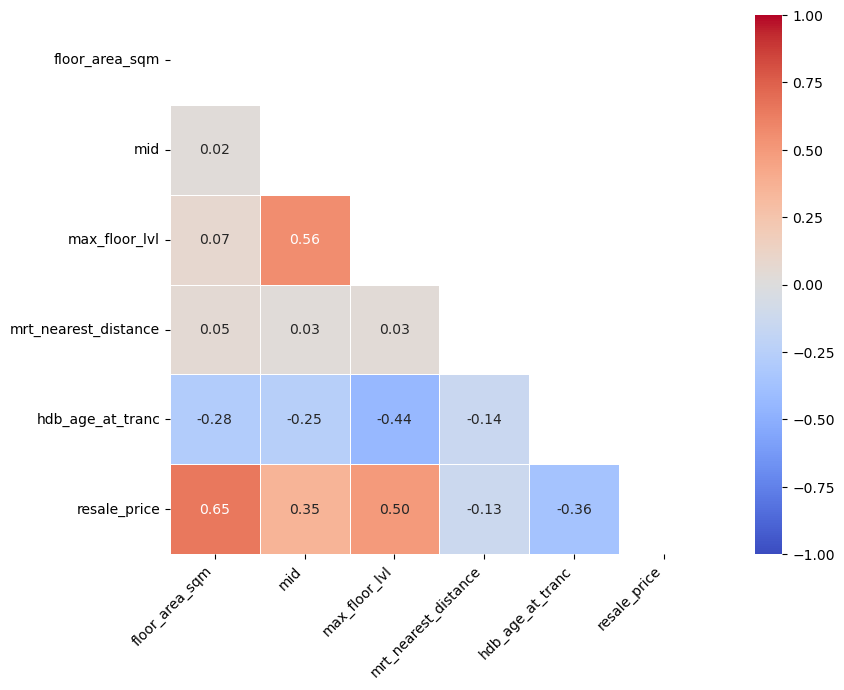

In [11]:
# Use Seaborn's heatmap with pandas .corr() to visualize correlations between all numeric features.
corr = df[numerical_columns+['resale_price']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (12,7))
sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap = "coolwarm",fmt='.2f')
plt.xticks(rotation=45, ha='right') 

### Bar charts for categorical features

* Visualise the distribution of flat type, flat model, transaction year amd planning area

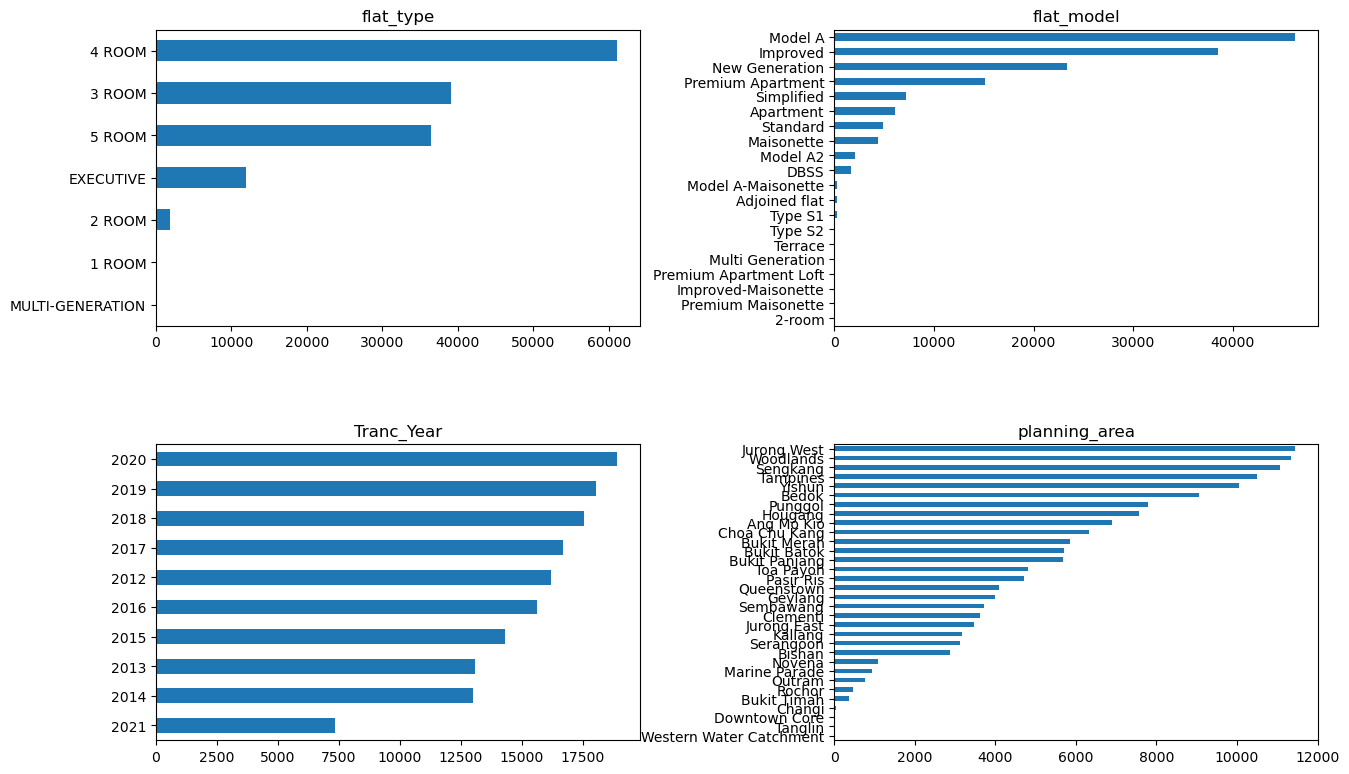

In [12]:
fig1 = plt.figure(figsize=(15,20))
fig1.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(categorical_columns):
    fig1.add_subplot(4,2,idx+1)
    df[d].value_counts().sort_values().plot(kind='barh')
    plt.title(d)

### Histogram for numerical features

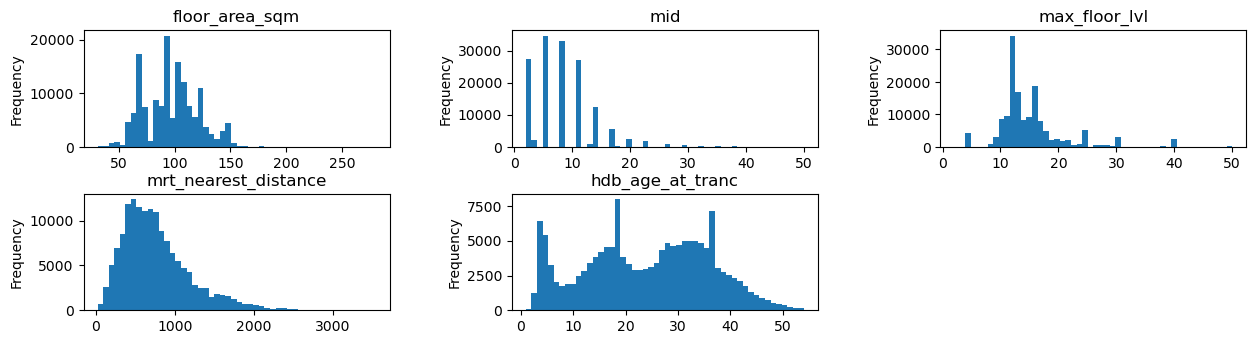

In [13]:
fig1b = plt.figure(figsize=(15,10))
fig1b.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(numerical_columns):
    fig1b.add_subplot(5,3,idx+1)
    df[d].plot(kind='hist',bins=50,title=d)

## Finding Outliers
* Scatter plot to check for outliers
* Box plots to focus on outliers for selected flat model
* Remove outliers from the dataset

Text(0.5, 1.0, 'Floor Area vs resale price')

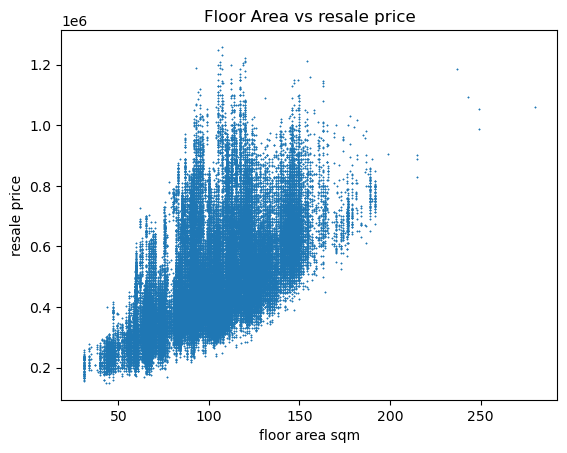

In [14]:
x = df['floor_area_sqm']
y = df['resale_price']
plt.scatter(x,y, marker='*',s=0.1)
plt.xlabel('floor area sqm')
plt.ylabel('resale price')
plt.title('Floor Area vs resale price')

In [15]:
def get_outliers_count (column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3 - Q1
    return sum((column<(Q1 - 1.5 * IQR)) | (column>(Q3 + 1.5 * IQR)))

#outliers = df.groupby('full_flat_type')['resale_price'].agg([get_outliers_count]).sort_values(by=['get_outliers_count'], ascending=False)
#outliers[:10]

#cols = 'resale_price'
#Q1 = df[cols].quantile(0.25)
#Q3 = df[cols].quantile(0.75)
#IQR = Q3 - Q1
#len(df.loc[df['full_flat_type'].isin(outliers)]) - len(df.loc[(df['full_flat_type'].isin(outliers))&(df[cols] < (Q3 + 1.5 * IQR))])

### List of flat types that are outliers

In [16]:
col = 'planning_area'

In [17]:
pd.options.display.float_format = '{:.2f}'.format
outliers_1 = df.groupby(col)['resale_price'].mean().sort_values(ascending=False)[:10]
outliers_1

planning_area
Tanglin         702600.00
Bukit Timah     702142.31
Outram          692618.97
Downtown Core   621383.48
Bishan          618369.87
Bukit Merah     555343.71
Queenstown      550512.74
Marine Parade   523842.45
Kallang         506686.95
Pasir Ris       502847.26
Name: resale_price, dtype: float64

In [18]:
outliers_2 = df.groupby(col)['resale_price'].max().sort_values(ascending=False)[:10]
outliers_2

planning_area
Outram        1258000.00
Bishan        1220000.00
Bukit Timah   1210000.00
Kallang       1205000.00
Bukit Merah   1200000.00
Novena        1185000.00
Queenstown    1170000.00
Toa Payoh     1150000.00
Clementi      1095000.00
Ang Mo Kio    1030000.00
Name: resale_price, dtype: float64

In [19]:
outliers = list(set(outliers_2.index.append(outliers_1.index)))
outliers

['Tanglin',
 'Outram',
 'Marine Parade',
 'Toa Payoh',
 'Bishan',
 'Downtown Core',
 'Kallang',
 'Bukit Timah',
 'Pasir Ris',
 'Queenstown',
 'Clementi',
 'Novena',
 'Ang Mo Kio',
 'Bukit Merah']

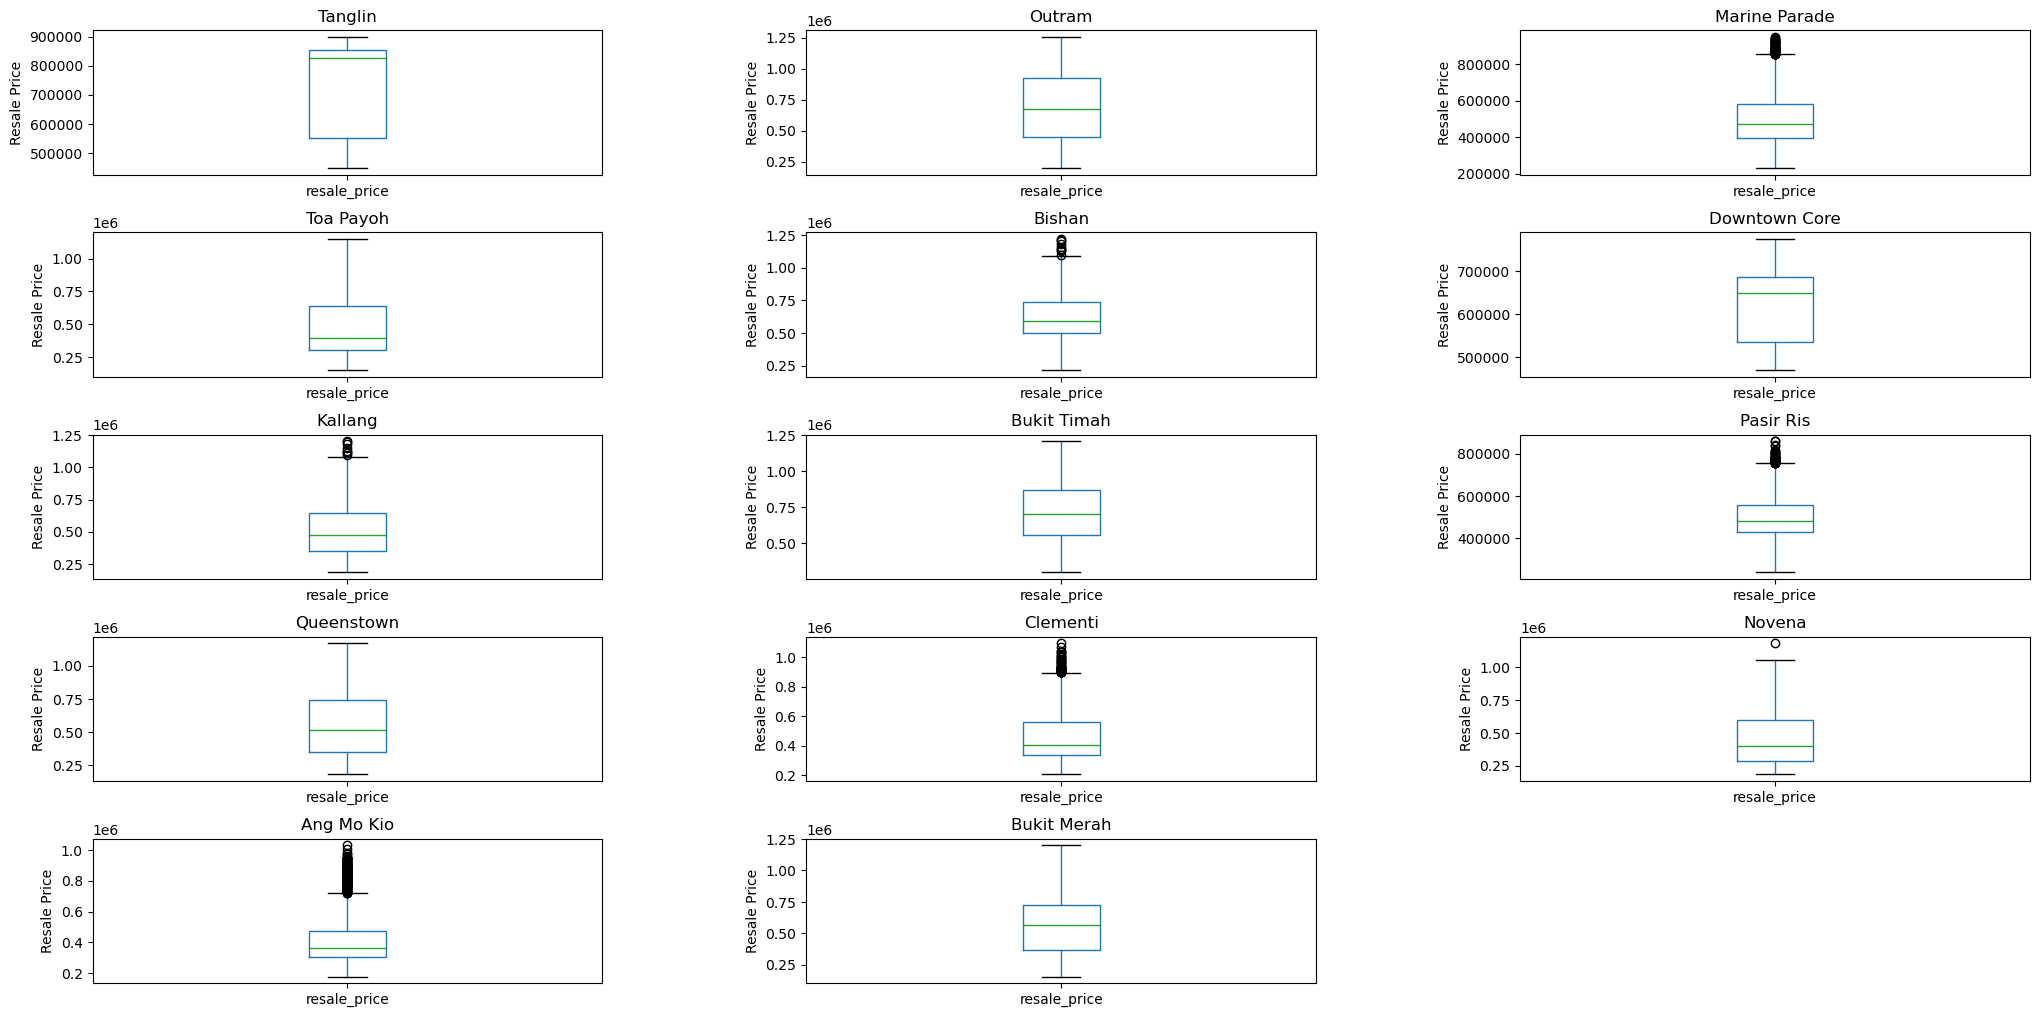

In [20]:
fig2 = plt.figure(figsize=(25,15))
fig2.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(outliers):
    fig2.add_subplot(6,3,idx+1)
    bp = df.loc[df[col]==d].boxplot(column='resale_price', grid=False)
    plt.ylabel('Resale Price')
    plt.title(d)

In [21]:
print(f"Before Original DataFrame : {df.shape}")

df_outlier = df.loc[df[col].isin(outliers)]
df = df.loc[~df[col].isin(outliers)]

print(f"Main Dataframe: {df.shape}")
print(f"Outliers DataFrame: {df_outlier.shape}")

Before Original DataFrame : (150634, 78)
Main Dataframe: (111349, 78)
Outliers DataFrame: (39285, 78)


### Check the outliers are removed from main dataframe by plotting boxplots

### Plot scatter plot again to check if outliers are removed

Text(0.5, 1.0, 'Floor Area vs resale price')

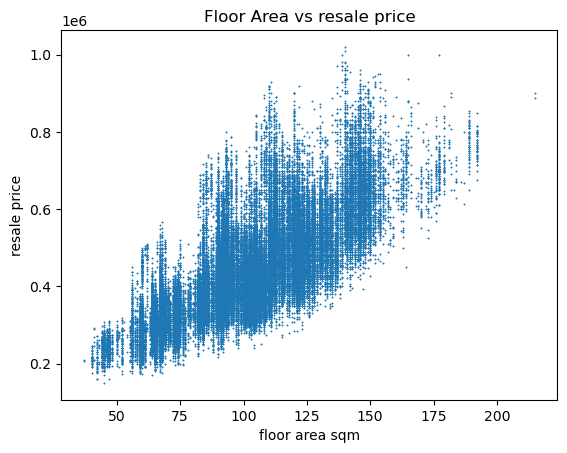

In [22]:
x = df['floor_area_sqm']
y = df['resale_price']
plt.scatter(x,y, marker='*',s=0.1)
plt.xlabel('floor area sqm')
plt.ylabel('resale price')
plt.title('Floor Area vs resale price')

Text(0.5, 1.0, 'Floor Area vs resale price (Outliers)')

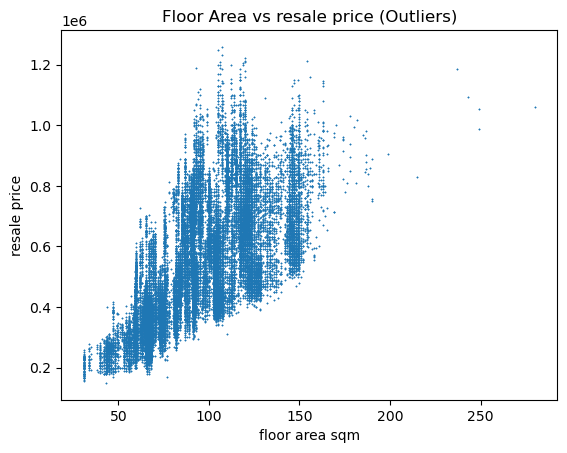

In [23]:
x = df_outlier['floor_area_sqm']
y = df_outlier['resale_price']
plt.scatter(x,y, marker='*',s=0.1)
plt.xlabel('floor area sqm')
plt.ylabel('resale price')
plt.title('Floor Area vs resale price (Outliers)')

### Scatter plots by Flat types

Grouping by Flat Types, the resale prices and floor area are not strongly linearly correlated

In [24]:
list(df['flat_type'].value_counts()[:3].index)

['4 ROOM', '5 ROOM', '3 ROOM']

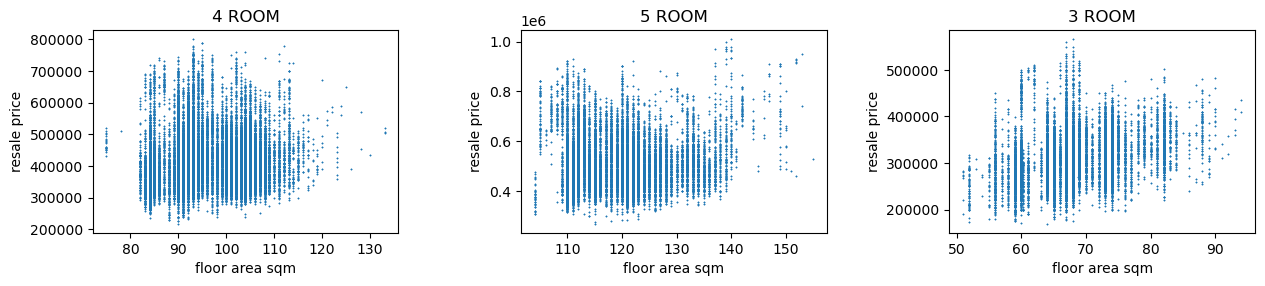

In [25]:
fig3 = plt.figure(figsize=(15,10))
fig3.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(df['flat_type'].value_counts()[:3].index):
    x = df.loc[df['flat_type']==d]['floor_area_sqm']
    y = df.loc[df['flat_type']==d]['resale_price']
    fig3.add_subplot(3,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.xlabel('floor area sqm')
    plt.ylabel('resale price')
    plt.title(d)

### Scatter plots by Planning area

After grouping by planning area, we can see linear correlation between floor area and resale prices

In [26]:
list(df['planning_area'].value_counts()[:3].index)

['Jurong West', 'Woodlands', 'Sengkang']

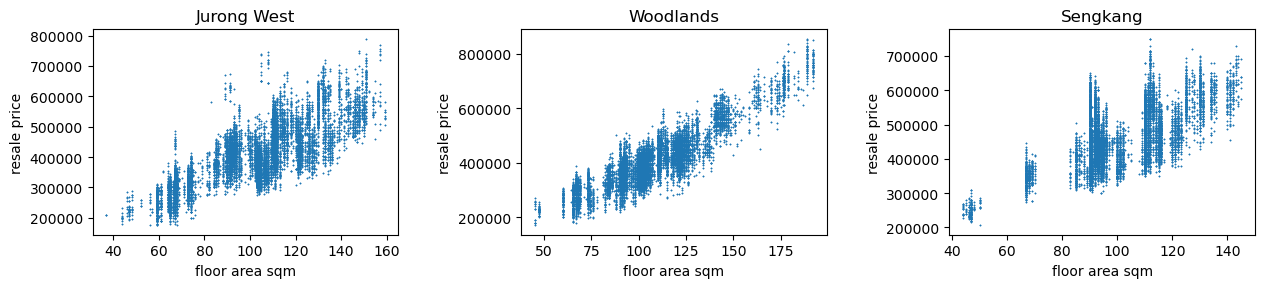

In [27]:
fig4 = plt.figure(figsize=(15,40))
fig4.subplots_adjust(hspace=0.4,wspace=0.4)
for idx, d in enumerate(['Jurong West', 'Woodlands', 'Sengkang']):
    x = df.loc[(df['planning_area']==d)]['floor_area_sqm']
    y = df.loc[(df['planning_area']==d)]['resale_price']
    fig4.add_subplot(11,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.xlabel('floor area sqm')
    plt.ylabel('resale price')
    plt.title(d)

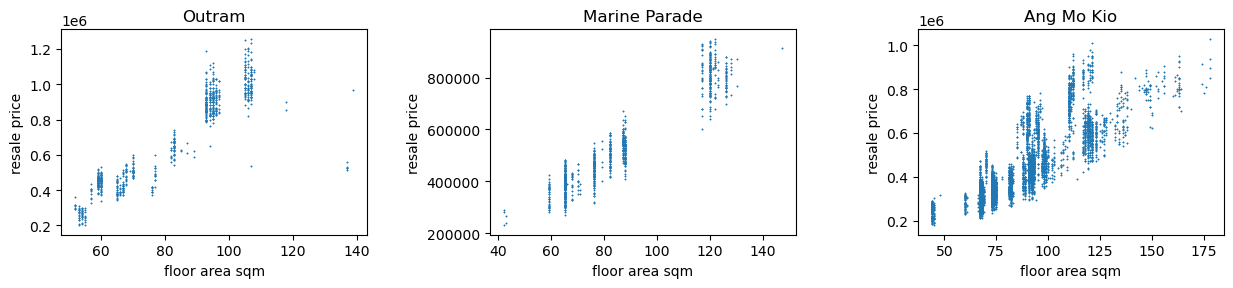

In [28]:
fig4 = plt.figure(figsize=(15,40))
fig4.subplots_adjust(hspace=0.4,wspace=0.4)
for idx, d in enumerate(['Outram', 'Marine Parade', 'Ang Mo Kio']):
    x = df_outlier.loc[(df_outlier['planning_area']==d)]['floor_area_sqm']
    y = df_outlier.loc[(df_outlier['planning_area']==d)]['resale_price']
    fig4.add_subplot(11,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.xlabel('floor area sqm')
    plt.ylabel('resale price')
    plt.title(d)

## Feature Engineering and Train Test Split

### Setup features and target

* Let X be the combination of selected numerical and categorical columns
* Let y be the target resale price column
* Double check if there are empty or null values in X

In [29]:
X= df[numerical_columns+categorical_columns]
y= df['resale_price']

X_o= df_outlier[numerical_columns+categorical_columns]
y_o= df_outlier['resale_price']

nulls = {k:v for k,v in dict(X.isnull().sum()).items() if v>0}
for k,v in nulls.items():
    print(f"Empty rows in column [{k}]: {v}")
    
nulls = {k:v for k,v in dict(X_o.isnull().sum()).items() if v>0}
for k,v in nulls.items():
    print(f"Empty rows in column [{k}]: {v}")
    
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_o,y_o,test_size = 0.2,random_state = 42)

## Model Building

In [30]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

In [31]:
#%%time
#
#def gs_fit(X_train,y_train):
#        """
#        Function to grid search each model with its hyperparameters
#        """
#        
#        models = {
#            'LinearRegression': LinearRegression(),
#            'Ridge': Ridge(),
#            'Lasso': Lasso()
#        }
#        
#        params = {
#            'LinearRegression':{ 
#                    },
#            'Ridge': {
#                'Estimator__alpha': [0.001, 0.01, 0.1,1,10]
#                },
#            'Lasso': {
#                'Estimator__alpha': [0.001, 0.01]
#                }  
#        }
#
#        for name in models.keys():
#            est = models[name]
#            est_params = params[name]
#            pipe = Pipeline([
#                ('Preprocessor',preprocessor),
#                ('Estimator', est)])
#            gs = GridSearchCV(pipe, cv=5,scoring='neg_root_mean_squared_error',param_grid=est_params)
#            gs.fit(X_train, y_train)
#            print(f"Best Score for {name}: {-gs.best_score_}")
#            print(f"Best Params for {name}: {gs.best_params_}")
#            
#gs_fit(X_train,y_train)

### Model selection
* After running through the grid search, Ridge appears to give the lowest RMSE socre, so we will stick to using Ridge

In [32]:
%%time
model = Ridge()
pipe = make_pipeline(preprocessor, model)
hyperparameters = {'ridge__alpha': [0.001, 0.01, 0.1,1,10]}
gs = GridSearchCV(pipe, hyperparameters,cv=5,scoring='neg_root_mean_squared_error')
gs.fit(X_train,y_train)
print(f"Best Score: {-gs.best_score_}")
print(f"Best Params: {gs.best_params_}")

Best Score: 42846.42914886157
Best Params: {'ridge__alpha': 0.01}
CPU times: total: 25 s
Wall time: 8.96 s


In [33]:
%%time
model = Ridge()
pipe = make_pipeline(preprocessor, model)
hyperparameters = {'ridge__alpha': [0.001, 0.01, 0.1,1,10]}
gs_o = GridSearchCV(pipe, hyperparameters,cv=5,scoring='neg_root_mean_squared_error')
gs_o.fit(X_train_o,y_train_o)
print(f"Best Score for outlier: {-gs_o.best_score_}")
print(f"Best Params for outlier: {gs_o.best_params_}")

Best Score for outlier: 48981.622248520434
Best Params for outlier: {'ridge__alpha': 0.01}
CPU times: total: 11.1 s
Wall time: 3.52 s


In [34]:
results = pd.DataFrame(gs.cv_results_)
results_o = pd.DataFrame(gs_o.cv_results_)

## Model Evaluation

In [35]:
predicted = gs.best_estimator_.predict(X_test)
mse = metrics.mean_squared_error(y_test, predicted)
print(f"Test score = {np.sqrt(mse):.3f}")
print("The mean cross-validation rmse is: "
      f"{-results['mean_test_score'].mean():.0f} ± {results['std_test_score'].mean():.0f}")

predicted = gs_o.best_estimator_.predict(X_test_o)
mse = metrics.mean_squared_error(y_test_o, predicted)
print(f"Test score for outlier = {np.sqrt(mse):.3f}")
print("The mean cross-validation rmse for outlier is: "
      f"{-results_o['mean_test_score'].mean():.0f} ± {results_o['std_test_score'].mean():.0f}")

Test score = 43432.288
The mean cross-validation rmse is: 42856 ± 564
Test score for outlier = 49588.321
The mean cross-validation rmse for outlier is: 49001 ± 188


In [36]:
def get_coeffs_from_gs(gs):
    coefficients = gs.best_estimator_[1].coef_
    out_columns_numerical = gs.best_estimator_[0].transformers_[1][2]
    out_columns_category = list(gs.best_estimator_[0].transformers_[0][1].get_feature_names())
    out_columns = out_columns_category+out_columns_numerical
    gs_coef = sorted(list(zip(np.round(coefficients,3),out_columns)),key=lambda x: x[0],reverse=True)
    return gs_coef

In [37]:
coefs = get_coeffs_from_gs(gs)
print("Flat Type")
print(*[x for x in coefs if "x0" in x[1]],sep='\n')
print("Flat Model")
print(*[x for x in coefs if "x1" in x[1]],sep='\n')
print("Transaction Year")
print(*[x for x in coefs if "x2" in x[1]],sep='\n')
print("Planning Area")
print(*[x for x in coefs if "x3" in x[1]],sep='\n')
print("Numerical Features")
print(*[x for x in coefs if not x[1].startswith('x')],sep='\n')

Flat Type
(60498.007, 'x0_MULTI-GENERATION')
(13222.247, 'x0_EXECUTIVE')
(-5658.247, 'x0_5 ROOM')
(-10787.045, 'x0_4 ROOM')
(-13200.484, 'x0_3 ROOM')
(-44074.478, 'x0_2 ROOM')
Flat Model
(90625.622, 'x1_DBSS')
(83253.1, 'x1_Improved-Maisonette')
(60526.827, 'x1_Model A-Maisonette')
(60498.007, 'x1_Multi Generation')
(37830.456, 'x1_Premium Apartment Loft')
(34727.586, 'x1_Adjoined flat')
(22461.202, 'x1_Premium Maisonette')
(7929.457, 'x1_Maisonette')
(-2985.866, 'x1_2-room')
(-19176.616, 'x1_Apartment')
(-46834.2, 'x1_Premium Apartment')
(-49259.774, 'x1_New Generation')
(-49271.743, 'x1_Standard')
(-52217.576, 'x1_Simplified')
(-55305.779, 'x1_Improved')
(-61009.382, 'x1_Model A2')
(-61791.322, 'x1_Model A')
Transaction Year
(32675.834, 'x2_2013')
(29660.054, 'x2_2021')
(17180.068, 'x2_2012')
(3848.604, 'x2_2014')
(-2431.06, 'x2_2020')
(-13731.091, 'x2_2016')
(-14217.18, 'x2_2015')
(-16593.377, 'x2_2019')
(-16658.286, 'x2_2017')
(-19733.566, 'x2_2018')
Planning Area
(176202.34, 'x3_C

In [38]:
coefs = get_coeffs_from_gs(gs_o)
print("Flat Type")
print(*[x for x in coefs if "x0" in x[1]],sep='\n')
print("Flat Model")
print(*[x for x in coefs if "x1" in x[1]],sep='\n')
print("Transaction Year")
print(*[x for x in coefs if "x2" in x[1]],sep='\n')
print("Planning Area")
print(*[x for x in coefs if "x3" in x[1]],sep='\n')
print("Numerical Features")
print(*[x for x in coefs if not x[1].startswith('x')],sep='\n')

Flat Type
(33689.939, 'x0_1 ROOM')
(28114.236, 'x0_5 ROOM')
(11034.958, 'x0_4 ROOM')
(5420.763, 'x0_MULTI-GENERATION')
(-1842.048, 'x0_EXECUTIVE')
(-27346.314, 'x0_3 ROOM')
(-49071.533, 'x0_2 ROOM')
Flat Model
(328208.331, 'x1_Terrace')
(67425.124, 'x1_Type S2')
(23297.616, 'x1_Maisonette')
(23219.749, 'x1_Model A-Maisonette')
(16438.588, 'x1_Premium Apartment Loft')
(5420.763, 'x1_Multi Generation')
(2004.054, 'x1_2-room')
(1108.187, 'x1_Type S1')
(-3953.016, 'x1_DBSS')
(-19875.808, 'x1_Adjoined flat')
(-27987.949, 'x1_Apartment')
(-39273.371, 'x1_Standard')
(-66206.274, 'x1_Premium Apartment')
(-68443.124, 'x1_Improved')
(-73622.826, 'x1_New Generation')
(-79631.363, 'x1_Simplified')
(-88128.683, 'x1_Model A')
Transaction Year
(21660.351, 'x2_2021')
(17619.688, 'x2_2013')
(-470.227, 'x2_2014')
(-2297.591, 'x2_2020')
(-3518.377, 'x2_2012')
(-4674.48, 'x2_2016')
(-4760.248, 'x2_2017')
(-6985.677, 'x2_2018')
(-7017.071, 'x2_2019')
(-9556.369, 'x2_2015')
Planning Area
(155065.426, 'x3_Ma

## Prediction

In [39]:
test_df = pd.read_csv("../data/test.csv")
test_df.head(2)

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,114982,2012-11,YISHUN,4 ROOM,173,YISHUN AVE 7,07 TO 09,84.00,Simplified,1987,...,92,0,1.43,103.83,156.32,Ahmad Ibrahim Secondary School,218,0,1.44,103.83
1,95653,2019-08,JURONG WEST,5 ROOM,986C,JURONG WEST ST 93,04 TO 06,112.00,Premium Apartment,2008,...,45,0,1.34,103.70,739.37,Jurong West Secondary School,199,0,1.34,103.70


In [40]:
check_dataframe_shape_null_zeroes(test_df)

Data frame shape: (16737, 76)


Empty rows in column [Mall_Nearest_Distance]: 84
Empty rows in column [Mall_Within_500m]: 10292
Empty rows in column [Mall_Within_1km]: 2786
Empty rows in column [Mall_Within_2km]: 213
Empty rows in column [Hawker_Within_500m]: 10755
Empty rows in column [Hawker_Within_1km]: 6729
Empty rows in column [Hawker_Within_2km]: 3254


Rows with zeroes in column [1room_sold]: 16730
Rows with zeroes in column [2room_sold]: 16027
Rows with zeroes in column [3room_sold]: 10607
Rows with zeroes in column [4room_sold]: 3297
Rows with zeroes in column [5room_sold]: 7002
Rows with zeroes in column [exec_sold]: 13916
Rows with zeroes in column [multigen_sold]: 16727
Rows with zeroes in column [studio_apartment_sold]: 16592
Rows with zeroes in column [1room_rental]: 16711
Rows with zeroes in column [2room_rental]: 16516
Rows with zeroes in column [3room_rental]: 16319
Rows with zeroes in column [other_room_rental]: 16736
Rows with zeroes in column [Mall_Nearest_Distance]

In [41]:
test_df['hdb_age_at_tranc'] = test_df['Tranc_Year']-test_df['lease_commence_date']

In [42]:
col = ['Hawker_Within_2km','Mall_Within_2km', 'Mall_Nearest_Distance' ]
for i in col:
    mean = np.mean(test_df[i])
    test_df[i].fillna(value=mean, inplace=True)

In [43]:
print(f"Before Original DataFrame : {test_df.shape}")

col = 'planning_area'
test_df_o = test_df.loc[test_df[col].isin(outliers)]
test_df = test_df.loc[~test_df[col].isin(outliers)]

print(f"Main Dataframe: {test_df.shape}")
print(f"Outliers DataFrame: {test_df_o.shape}")

Before Original DataFrame : (16737, 77)
Main Dataframe: (12228, 77)
Outliers DataFrame: (4509, 77)


In [44]:
pred = gs.best_estimator_.predict(test_df)
pred.shape

(12228,)

In [45]:
pred_o = gs_o.best_estimator_.predict(test_df_o)
pred_o.shape

(4509,)

In [46]:
sub_df = pd.DataFrame()
sub_df["Id"] = test_df['id'].append(test_df_o['id'])
sub_df["Predicted"] = np.concatenate((pred,pred_o), axis=0)
sub_df.to_csv("../data/sub_reg.csv", index=False)

In [47]:
submit = pd.read_csv("../data/sub_reg.csv")
submit.shape

(16737, 2)